- annotate each & `infercnvpy` for each
    - with `celltypist`
    - neftel score with `decoupler`
- scvi integration & bulk annotate

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

# scRNA-seq analysis pipeline
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import decoupler as dc

# adjunctive
import infercnvpy as cnv
import celltypist
import mygene

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
%matplotlib inline

# # Models & Calculation
from scipy.stats import median_abs_deviation as mad
import scipy.sparse as sp
import scvi
# from scvi import autotune
# from ray import tune
# import ray

In [2]:
# R integration
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import anndata2ri
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /home/jiehoonk/micromamba/envs/sc_base_with_r/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
: Successfullly loaded R Profile
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


In [3]:
%%R
suppressPackageStartupMessages({
    # library(tidyverse)
    # library(Seurat)
    # library(scater)
    library(scDblFinder) 
    # library(BiocParallel)
    # library(scry)
})

In [4]:
def map_ensembl_to_symbols(var_index, species = "human"):
    ensembl_ids = list(var_index)
    results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species=species)
    mapping_dict = {res['query']: res.get('symbol', res['query']) for res in results}
    return mapping_dict

def mad_outlier(adata, metric: str, nmads = 5, upper_only = False):
    M = adata.obs[metric]
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (np.median(M) + nmads * mad(M) < M)
    return (M > np.median(M) + nmads * mad(M))

def qc(adata, species = "human"):
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_counts=1)
    adata.var["mt"] = adata.var_names.str.startswith("MT-") if species == "human" else adata.var_names.str.startswith("mt-")
    adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL')) if species == "human" else adata.var_names.str.startswith(('Rps', 'Rpl'))
    adata.var['hb'] = adata.var_names.str.contains(('^HB[^(P)]')) if species == "human" else adata.var_names.str.contains(('^Hb[^(p)]'))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=True, inplace=True) 
    
    not_need = ['total_counts_mt', 'log1p_total_counts_mt',
                'total_counts_ribo','log1p_total_counts_ribo',
                'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in not_need]]
    print('Filtering cells below 200 genes and Returning adata with QC metrics')
    return adata
    
# codes from sanbomics
def qc_plot(adatas, value = "pct_counts_mt"):
    df = pd.concat([adata.obs for adata in adatas]).sort_values('sample_id')
    print("You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts")

    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df, row="sample_id", hue="sample_id", aspect=15, height=0.5, palette="tab20")
    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, value)
    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')
    plt.show()
   

def pp(adata, mt_upper = 25):
    adata = adata[adata.obs.pct_counts_mt < mt_upper] 
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]
    adata.uns['cells_removed'] = sum(bool_vector)
    print('Returning adata with outliers removed')
    adata = remove_doublets(adata)
    return adata


def remove_doublets(adata):
    data_mat = adata.X.T
    %R -i data_mat -o doublet_score -o doublet_class set.seed(123);sce = scDblFinder(SingleCellExperiment(list(counts=data_mat))); doublet_score = sce$scDblFinder.score; doublet_class = sce$scDblFinder.class
    adata.obs["scDblFinder_score"] = doublet_score
    adata.obs["scDblFinder_class"] = doublet_class
    print(adata.obs.scDblFinder_class.value_counts())
    print('Returning adata with doublet removed')
    adata.uns["doublets_removed"] = sum(adata.obs["scDblFinder_class"] == "doublet")
    
    sce.pp.scrublet(adata, expected_doublet_rate=0.1)
    return adata[(adata.obs.scDblFinder_class == 'singlet') | ~(adata.obs.predicted_doublet)]

def print_clusters(df, n_genes = 5, resolution = 1, scvi = False):
    resolution_name = "leiden_res" + str(resolution).replace('.','_')
    clusters = adata.obs[resolution_name].cat.categories

    group = 'group' if not scvi else 'group1'
    if not scvi:
        for cluster in clusters:
            top_genes = df[df[group] == cluster].head(n_genes)['names']
            res = ', '.join(top_genes)
            print(f'Cluster {cluster}: {res}')
    else:
        for cluster in clusters:
            top_genes = df[df[group] == cluster].head(n_genes).index
            res = ', '.join(top_genes)
            print(f'Cluster {cluster}: {res}')
            
            
def annotate_with_markers(adata, gene_markers, resolution=0.5):
    resolution_name = "leiden_res" + str(resolution).replace('.','_')
    sc.tl.leiden(adata, key_added=f'{resolution_name}', resolution=resolution)
    for ct in gene_markers.keys(): 
        print(f"{ct.upper()}:")  
        sc.pl.umap(
            adata,
            color=gene_markers[ct],
            vmax="p99", 
            sort_order=False, 
            frameon=False,
            cmap="Reds", 
        )
        print("\n\n\n")
    sc.pl.dotplot(
        adata,
        groupby=resolution_name,
        var_names= gene_markers, 
        standard_scale="var", 
    )    

# 1. Load samples from output of `Cellbender` v8.0.0

In [5]:
def load_data(sample):
    adata = sc.read_10x_h5(os.path.join(data_dir, sample))
    
    sample = sample.split('_')[0]
    adata.obs['sample_id'] = sample
    adata.obs['tissue'] = adata.obs.index.map(lambda x: "Tumor" if sample[-1] == 'T' else "SVZ")
    adata.obs['patient_id'] = sample[:-1]
    adata.obs['author'] = 'tnl'
    adata.obs['barcode'] = adata.obs.index
    adata.obs.index = adata.obs['sample_id'] + "_" + adata.obs['barcode']
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    adata.X = adata.X.tocsc().astype(np.float32)
    return adata

data_dir = '../../processed_data/cellbender_out'
samples = [f for f in os.listdir(data_dir) if f.endswith('.h5')]
adatas = [load_data(sample) for sample in samples]

for adata in adatas:
    print(adata.obs['sample_id'][0], " : ", np.max(adata.X), np.min(adata.X))

S1T  :  475.0 0.0
S1V  :  1582.0 0.0
S2T  :  3087.0 0.0
S2V  :  2992.0 0.0
S3T  :  1058.0 0.0
S3V  :  258.0 0.0
S4T  :  4370.0 0.0
S4V  :  13294.0 0.0
S5T  :  6976.0 0.0
S5V  :  2366.0 0.0
S6T  :  31650.0 0.0
S6V  :  3348.0 0.0


# 2. Preprocess

In [6]:
adatas = [qc(adata, species="human") for adata in adatas] 

Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics
Filtering cells below 200 genes and Returning adata with QC metrics


You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts


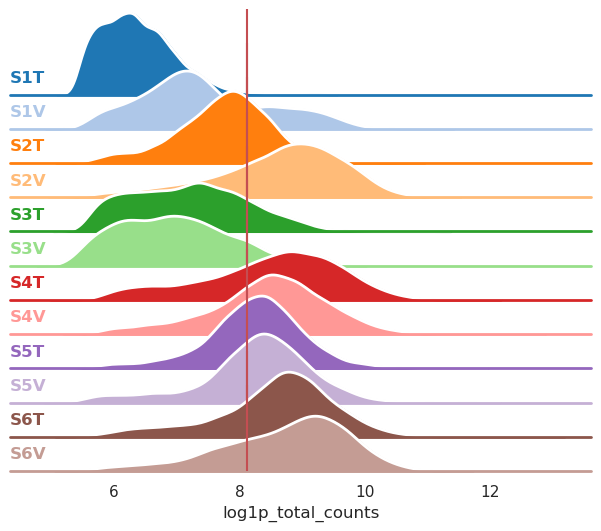

In [7]:
qc_plot(adatas, 'log1p_total_counts')

You can check for pct_counts_mt , n_genes , pct_counts_in_top_20_genes , log1p_total_counts


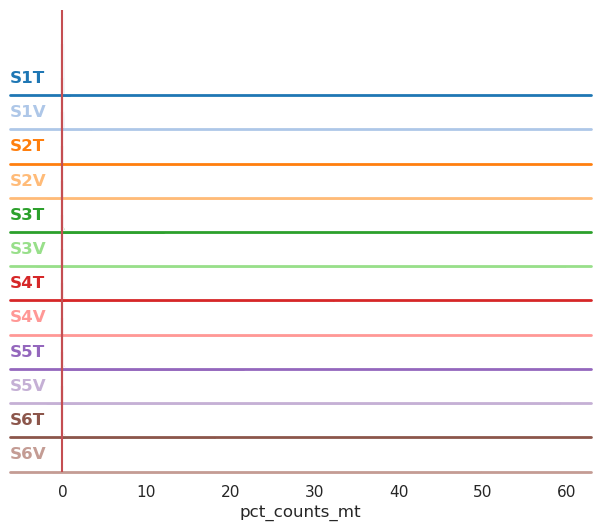

In [8]:
qc_plot(adatas, 'pct_counts_mt')

In [9]:
adatas = [pp(adata) for adata in adatas]

for adata in adatas:
    print("total cells :", len(adata), 
          ", removed cells :", adata.uns['cells_removed'], 
          ", removed doublets :", adata.uns['doublets_removed'], 
          ", removed doublet (scDblFinder) % : {:.2f} ".format(adata.uns['doublets_removed']/len(adata)*100),
          ", removed doublet (scrublet) % : {:.2f}".format(adata.obs.predicted_doublet.sum()/len(adata)*100))
    print('check doublet rate is about 4.5% in 5000 cells')

Returning adata with outliers removed


Creating ~5281 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1045 cells excluded from training.
iter=1, 1045 cells excluded from training.
iter=2, 1045 cells excluded from training.
Threshold found:0.403
527 (8%) doublets called


scDblFinder_class
singlet    6074
doublet     527
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~6283 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1512 cells excluded from training.
iter=1, 1512 cells excluded from training.
iter=2, 1512 cells excluded from training.
Threshold found:0.425
870 (11.1%) doublets called


scDblFinder_class
singlet    6983
doublet     870
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~5532 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1225 cells excluded from training.
iter=1, 1225 cells excluded from training.
iter=2, 1225 cells excluded from training.
Threshold found:0.375
594 (8.6%) doublets called


scDblFinder_class
singlet    6321
doublet     594
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~3016 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 527 cells excluded from training.
iter=1, 527 cells excluded from training.
iter=2, 527 cells excluded from training.
Threshold found:0.37
226 (6%) doublets called


scDblFinder_class
singlet    3544
doublet     226
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~4126 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 697 cells excluded from training.
iter=1, 697 cells excluded from training.
iter=2, 697 cells excluded from training.
Threshold found:0.509
415 (8%) doublets called


scDblFinder_class
singlet    4742
doublet     415
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~1500 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 181 cells excluded from training.
iter=1, 181 cells excluded from training.
iter=2, 181 cells excluded from training.
Threshold found:0.372
28 (3.4%) doublets called


scDblFinder_class
singlet    802
doublet     28
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~6350 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1848 cells excluded from training.
iter=1, 1848 cells excluded from training.
iter=2, 1848 cells excluded from training.
Threshold found:0.302
689 (8.7%) doublets called


scDblFinder_class
singlet    7248
doublet     689
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~5241 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 978 cells excluded from training.
iter=1, 978 cells excluded from training.
iter=2, 978 cells excluded from training.
Threshold found:0.256
412 (6.3%) doublets called


scDblFinder_class
singlet    6139
doublet     412
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~7212 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1535 cells excluded from training.
iter=1, 1535 cells excluded from training.
iter=2, 1535 cells excluded from training.
Threshold found:0.284
958 (10.6%) doublets called


scDblFinder_class
singlet    8057
doublet     958
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~1816 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 340 cells excluded from training.
iter=1, 340 cells excluded from training.
iter=2, 340 cells excluded from training.
Threshold found:0.303
105 (4.6%) doublets called


scDblFinder_class
singlet    2164
doublet     105
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~3901 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 868 cells excluded from training.
iter=1, 868 cells excluded from training.
iter=2, 868 cells excluded from training.
Threshold found:0.38
366 (7.5%) doublets called


scDblFinder_class
singlet    4510
doublet     366
Name: count, dtype: int64
Returning adata with doublet removed
Returning adata with outliers removed


Creating ~2041 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 359 cells excluded from training.
iter=1, 359 cells excluded from training.
iter=2, 359 cells excluded from training.
Threshold found:0.372
111 (4.4%) doublets called


scDblFinder_class
singlet    2440
doublet     111
Name: count, dtype: int64
Returning adata with doublet removed
total cells : 6601 , removed cells : 128 , removed doublets : 527 , removed doublet (scDblFinder) % : 7.98  , removed doublet (scrublet) % : 0.00
check doublet rate is about 4.5% in 5000 cells
total cells : 7850 , removed cells : 1580 , removed doublets : 870 , removed doublet (scDblFinder) % : 11.08  , removed doublet (scrublet) % : 0.00
check doublet rate is about 4.5% in 5000 cells
total cells : 6536 , removed cells : 2934 , removed doublets : 594 , removed doublet (scDblFinder) % : 9.09  , removed doublet (scrublet) % : 1.35
check doublet rate is about 4.5% in 5000 cells
total cells : 3716 , removed cells : 863 , removed doublets : 226 , removed doublet (scDblFinder) % : 6.08  , removed doublet (scrublet) % : 0.13
check doublet rate is about 4.5% in 5000 cells
total cells : 5157 , removed cells : 3634 , removed doublets : 415 , removed doublet (scDblFinder) % : 8.05  , r

In [10]:
adatas

[View of AnnData object with n_obs × n_vars = 6601 × 28115
     obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet'
     var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed', 'doublets_removed', 'scrublet',
 View of AnnData object with n_obs × n_vars = 7850 × 32498
     obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doubl

In [11]:
adata = sc.concat(adatas, join = 'outer')
adata.layers['counts'] = adata.X.copy()
adata.raw = adata

In [12]:
adata.write('../../intermediate_output/1_before_integration.h5ad')

... storing 'sample_id' as categorical
... storing 'tissue' as categorical
... storing 'patient_id' as categorical
... storing 'author' as categorical
... storing 'barcode' as categorical


# 3. Normalize & scVI integration

In [14]:
batch_key = 'sample_id'

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

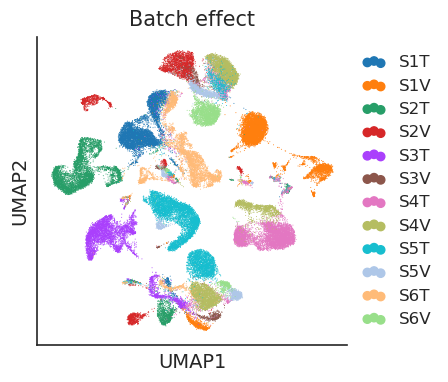

In [15]:
# check for batch effect 
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata)
sc.tl.pca(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
with mplscience.style_context():
    sc.pl.umap(bdata, color=[batch_key], title = "Batch effect") 
    plt.show()
del bdata

- run autotune & scVI integration in `Runpod`, refer to [2_tnl_runpod.ipynb](../tnl/2_tnl_runpod.ipynb)

# 4. Clustering and annotation
- bulk annotate with `celltypist` and `decoupler-py` markers
- then split into batches, re-annotate and inf `CNV`

In [54]:
adata = sc.read_h5ad('../../intermediate_output/2_after_scvi_autotune.h5ad')
adata

AnnData object with n_obs × n_vars = 62649 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

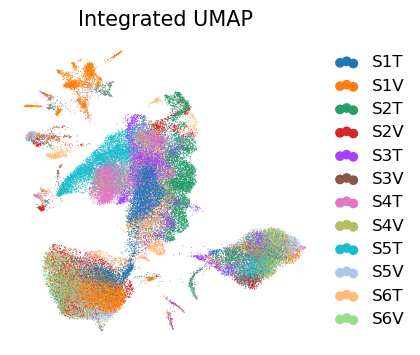

In [6]:
np.random.seed(777)
ri = np.random.permutation(list(range(adata.shape[0])))
with mplscience.style_context():
    sc.pl.umap(adata[ri,:], color = ['sample_id', 'tissue'], title = "Integrated UMAP", show=False, frameon=False)

## 1> celltypist

In [5]:
celltypist.models.get_all_models()

['Human_Longitudinal_Hippocampus.pkl',
 'Developing_Mouse_Brain.pkl',
 'GBmap_ref_hvg.pkl',
 'Developing_Human_Brain.pkl',
 'Human_AdultAged_Hippocampus.pkl',
 'GBmap_ref_model.pkl',
 'Mouse_Whole_Brain.pkl',
 'gbmap_sc_hvg3000_model.pkl']

In [55]:
models = [
    "Developing_Human_Brain.pkl",
    "Human_AdultAged_Hippocampus.pkl",
    "Human_Longitudinal_Hippocampus.pkl",
    "GBmap_ref_model.pkl",
    "GBmap_ref_hvg.pkl"
]

for model_name in models:
    model = celltypist.models.Model.load(model=model_name)
    
    bdata = adata.copy()
    sc.pp.normalize_total(bdata, target_sum=1e4)
    sc.pp.log1p(bdata)
    
    predictions = celltypist.annotate(bdata, model=model, mode='prob match', p_thres=0.5)
    predictions_adata = predictions.to_adata()
    
    base_name = model_name.split(".pkl")[0]
    key_suffix = base_name.replace(' ', '_').lower()
    
    adata.obs[f'{key_suffix}_anno'] = predictions_adata.obs['predicted_labels']
    adata.obs[f'{key_suffix}_conf_score'] = predictions_adata.obs['conf_score']
    
    del predictions_adata
    del bdata

INFO:celltypist.logger:🔬 Input data has 62649 cells and 36579 genes
INFO:celltypist.logger:🔗 Matching reference genes in the model
INFO:celltypist.logger:🧬 988 features used for prediction
INFO:celltypist.logger:⚖️ Scaling input data
INFO:celltypist.logger:🖋️ Predicting labels
INFO:celltypist.logger:✅ Prediction done!
INFO:celltypist.logger:🔬 Input data has 62649 cells and 36579 genes
INFO:celltypist.logger:🔗 Matching reference genes in the model
INFO:celltypist.logger:🧬 2133 features used for prediction
INFO:celltypist.logger:⚖️ Scaling input data
INFO:celltypist.logger:🖋️ Predicting labels
INFO:celltypist.logger:✅ Prediction done!
INFO:celltypist.logger:🔬 Input data has 62649 cells and 36579 genes
INFO:celltypist.logger:🔗 Matching reference genes in the model
INFO:celltypist.logger:🧬 2575 features used for prediction
INFO:celltypist.logger:⚖️ Scaling input data
INFO:celltypist.logger:🖋️ Predicting labels
INFO:celltypist.logger:✅ Prediction done!
INFO:celltypist.logger:🔬 Input data ha

## 2> decoupler

### A. PanglaoDB

In [56]:
pg_markers = dc.get_resource('PanglaoDB')
pg_markers = pg_markers[pg_markers['human'] & pg_markers['canonical_marker'] & (pg_markers['human_sensitivity'] > 0.5)]
pg_markers = pg_markers[~pg_markers.duplicated(['cell_type', 'genesymbol'])]

INFO:root:Downloading annotations for all proteins from the following resources: `['PanglaoDB']`


In [57]:
dc.run_ora(mat = adata, net = pg_markers, source = "cell_type", target = "genesymbol", min_n = 3, use_raw = False)
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

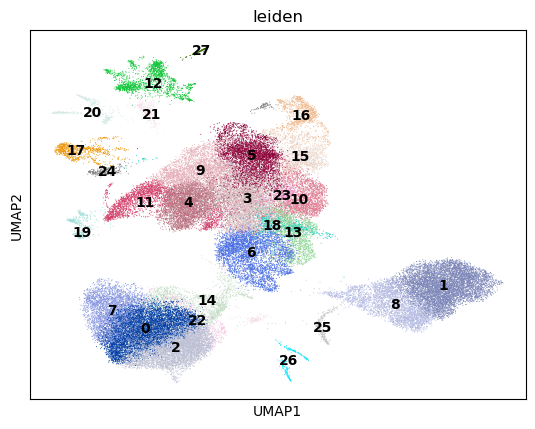

In [58]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

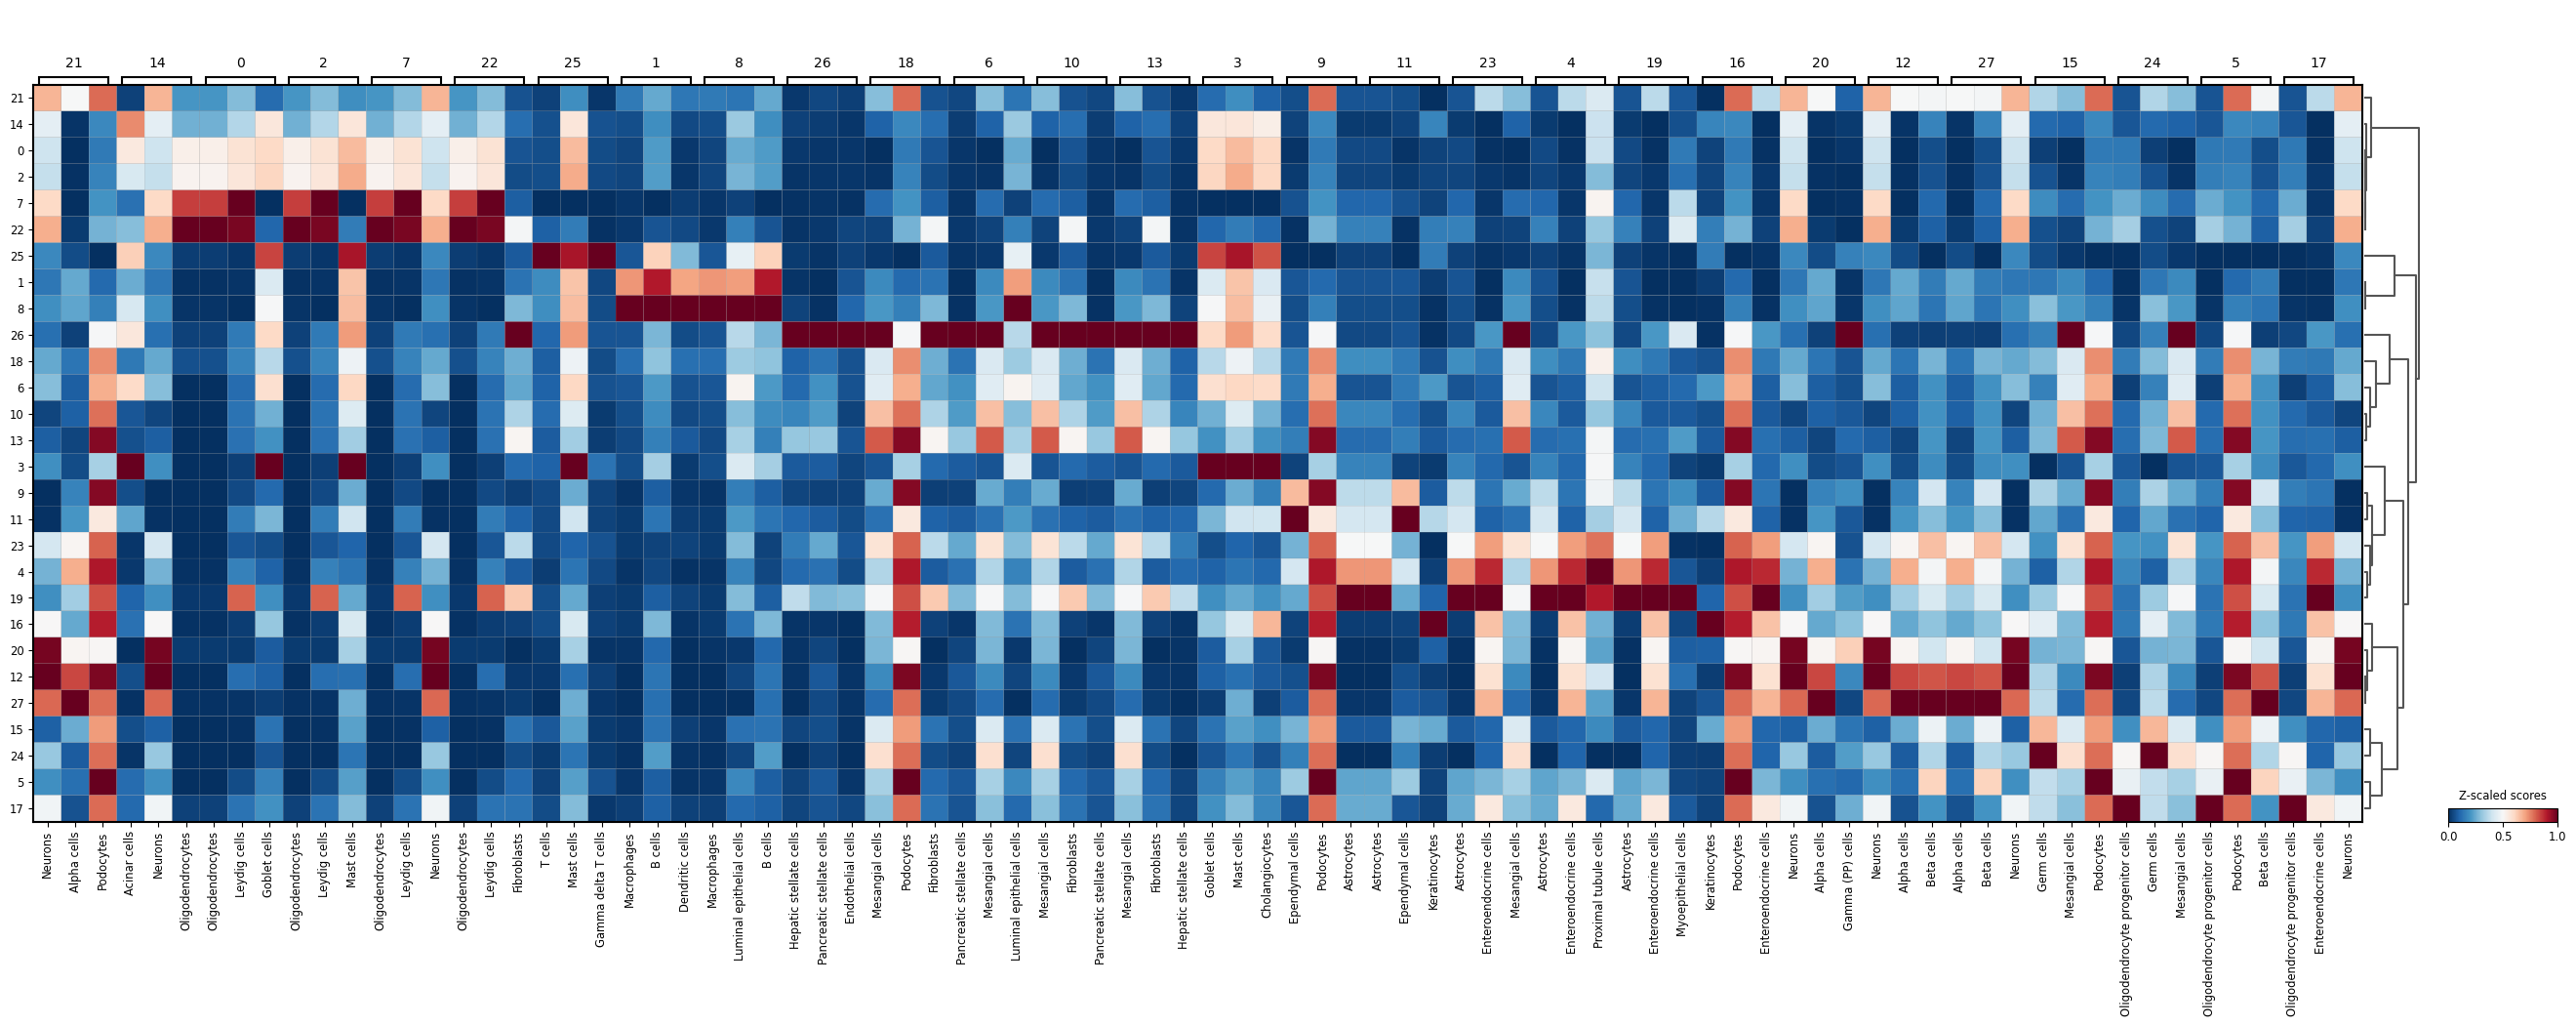

In [59]:
n_ctypes = 3
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [60]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Oligodendrocytes',
 '1': 'Macrophages',
 '10': 'Mesangial cells',
 '11': 'Astrocytes',
 '12': 'Neurons',
 '13': 'Mesangial cells',
 '14': 'Acinar cells',
 '15': 'Germ cells',
 '16': 'Keratinocytes',
 '17': 'Oligodendrocyte progenitor cells',
 '18': 'Mesangial cells',
 '19': 'Astrocytes',
 '2': 'Oligodendrocytes',
 '20': 'Neurons',
 '21': 'Neurons',
 '22': 'Oligodendrocytes',
 '23': 'Astrocytes',
 '24': 'Oligodendrocyte progenitor cells',
 '25': 'T cells',
 '26': 'Hepatic stellate cells',
 '27': 'Alpha cells',
 '3': 'Goblet cells',
 '4': 'Astrocytes',
 '5': 'Oligodendrocyte progenitor cells',
 '6': 'Pancreatic stellate cells',
 '7': 'Oligodendrocytes',
 '8': 'Macrophages',
 '9': 'Ependymal cells'}

### B. Markers from published literature

In [61]:
markers = pd.read_csv('../../markers/gbm_markers.csv')
markers = markers.melt(var_name = 'cell_type', value_name = 'genesymbol').dropna()
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,cell_type,genesymbol
0,MES2-like,HILPDA
1,MES2-like,ADM
2,MES2-like,DDIT3
3,MES2-like,NDRG1
4,MES2-like,HERPUD1
...,...,...
4061,TAM-BDM,PIM1
4062,TAM-BDM,FXYD5
4063,TAM-BDM,ARG2
4064,TAM-BDM,PQLC3


In [62]:
dc.run_ora(mat = adata, net = markers, source = "cell_type", target = "genesymbol", min_n = 1, use_raw = False)
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

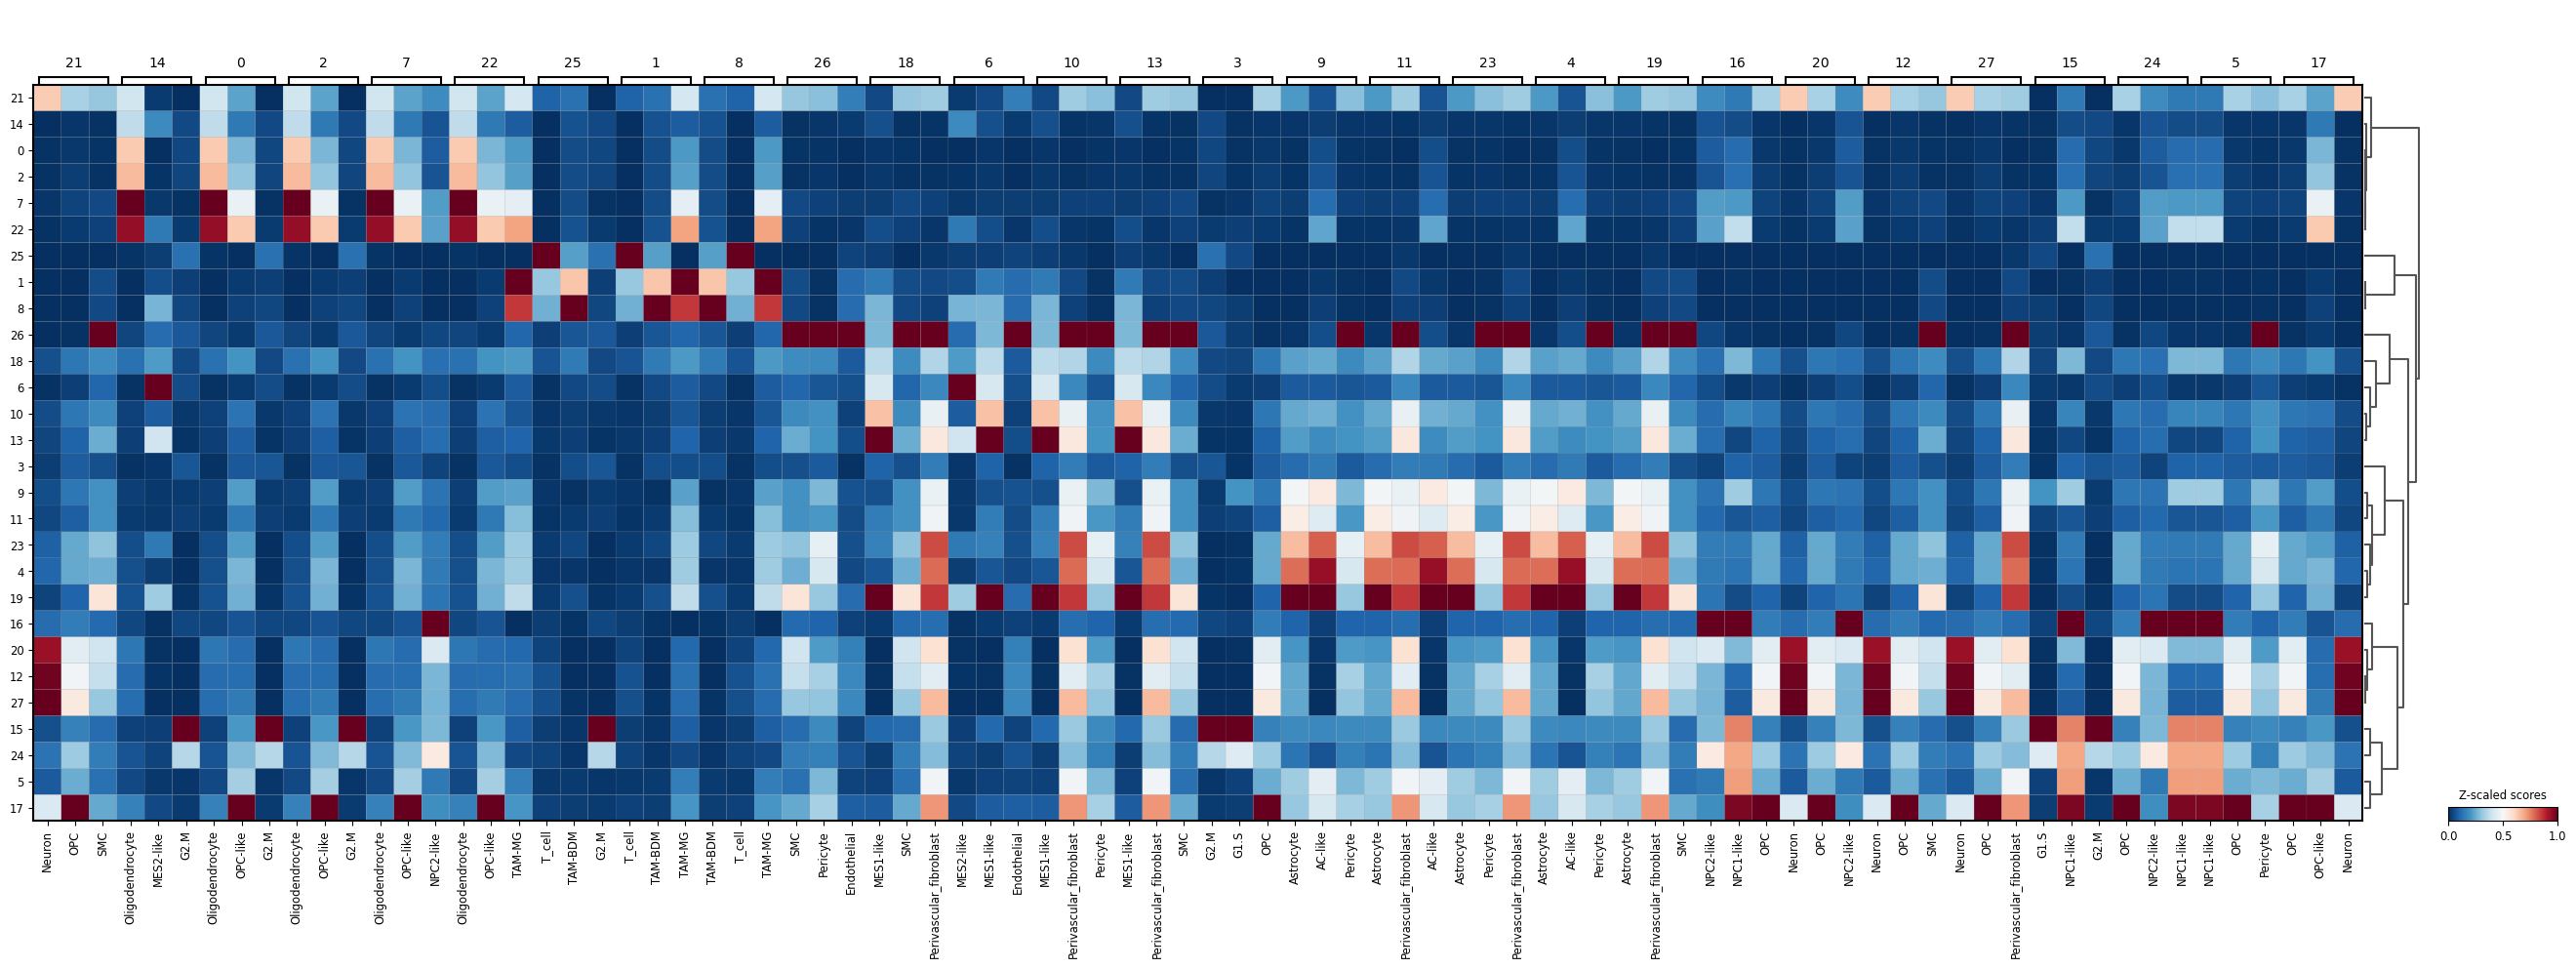

In [63]:
n_ctypes = 3
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')


In [64]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict = {k: annotation_dict[k] for k in sorted(annotation_dict.keys(), key=int)}
annotation_dict

{'0': 'Oligodendrocyte',
 '1': 'T_cell',
 '2': 'Oligodendrocyte',
 '3': 'G2.M',
 '4': 'Astrocyte',
 '5': 'NPC1-like',
 '6': 'MES2-like',
 '7': 'Oligodendrocyte',
 '8': 'TAM-BDM',
 '9': 'Astrocyte',
 '10': 'MES1-like',
 '11': 'Astrocyte',
 '12': 'Neuron',
 '13': 'MES1-like',
 '14': 'Oligodendrocyte',
 '15': 'G1.S',
 '16': 'NPC2-like',
 '17': 'OPC',
 '18': 'MES1-like',
 '19': 'Astrocyte',
 '20': 'Neuron',
 '21': 'Neuron',
 '22': 'Oligodendrocyte',
 '23': 'Astrocyte',
 '24': 'OPC',
 '25': 'T_cell',
 '26': 'SMC',
 '27': 'Neuron'}

### C. compare

In [65]:
labels = adata.obs[['leiden', 'developing_human_brain_anno',  'human_adultaged_hippocampus_anno','human_longitudinal_hippocampus_anno', 'gbmap_ref_model_anno', 'gbmap_ref_hvg_anno']].groupby('leiden').agg(lambda x:x.mode())
scores = adata.obs[['developing_human_brain_conf_score', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_conf_score', 'leiden']].groupby('leiden').agg(lambda x:x.mean())
last_check = labels.merge(right = scores, left_index=True, right_index=True)
last_check

,developing_human_brain_anno,human_adultaged_hippocampus_anno,human_longitudinal_hippocampus_anno,gbmap_ref_model_anno,gbmap_ref_hvg_anno,developing_human_brain_conf_score,human_longitudinal_hippocampus_conf_score,gbmap_ref_model_conf_score,gbmap_ref_hvg_conf_score
leiden,,,,,,,,,
0,Unassigned,mOli,Olig3,oligodendrocyte,oligodendrocyte,0.160875,0.696311,0.999169,0.983902
1,Unassigned,Microglia,Micro3,microglial cell,microglial cell,0.506462,0.761824,0.934416,0.897717
2,Unassigned,mOli,Unassigned,oligodendrocyte,oligodendrocyte,0.145471,0.590418,0.999888,0.994290
3,Unassigned,Unassigned,Unassigned,malignant cell,malignant cell,0.230764,0.215447,0.969973,0.961465
4,Unassigned,Astrocytes,Astro1,malignant cell,malignant cell,0.246010,0.690965,0.796319,0.950525
5,Unassigned,Astrocytes,Unassigned,malignant cell,malignant cell,0.152881,0.197981,0.961762,0.963365
6,Unassigned,Unassigned,Unassigned,malignant cell,malignant cell,0.200169,0.323893,0.983589,0.985263
7,Unassigned,mOli,Olig2|Olig4,oligodendrocyte,oligodendrocyte,0.130501,0.877254,0.999984,0.999657
8,Unassigned,Microglia,Unassigned,macrophage,macrophage,0.513678,0.676139,0.900921,0.856619


In [66]:
cell_annotation = {
    '0': 'oligodendrocyte',
    '1': 'microglial cell',
    '2': 'oligodendrocyte',
    '3': 'malignant cell',
    '4': 'malignant cell',
    '5': 'malignant cell',
    '6': 'malignant cell',
    '7': 'oligodendrocyte',
    '8': 'macrophage',
    '9': 'malignant cell',
    '10': 'malignant cell',
    '11': 'malignant cell', 
    '12': 'neuron',
    '13': 'malignant cell',
    '14': 'oligodendrocyte',
    '15': 'malignant cell',
    '16': 'malignant cell',
    '17': 'oligodendrocyte precursor cell',
    '18': 'malignant cell',
    '19': 'malignant cell',
    '20': 'neuron',
    '21': 'neuron',
    '22': 'oligodendrocyte',
    '23': 'malignant cell',
    '24': 'oligodendrocyte precursor cell',
    '25': 'mature T cell',
    '26': 'endothelial cell',
    '27': 'neuron'
}

adata.obs['cell_type'] = adata.obs.leiden.map(cell_annotation)
adata.obs.cell_type.value_counts()

cell_type
malignant cell                    30047
oligodendrocyte                   18235
microglial cell                    6748
macrophage                         3296
neuron                             2613
oligodendrocyte precursor cell     1150
mature T cell                       315
endothelial cell                    245
Name: count, dtype: int64

... storing 'cell_type' as categorical


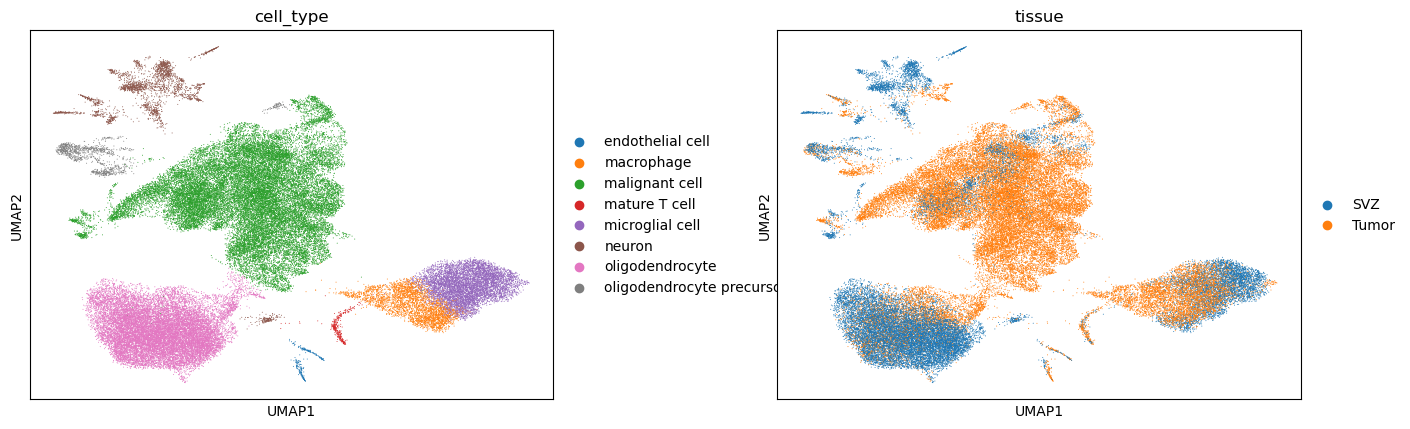

In [67]:
sc.pl.umap(adata, color = ['cell_type', 'tissue'], wspace = 0.3)

- need to check `astrocytes` and `radial glial cell`, annotate each with detail later on

- add cellarium annotations

In [36]:
import os
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd

from dotenv import load_dotenv
from cellarium.cas.client import CASClient
from cellarium.cas.postprocessing import insert_cas_ontology_aware_response_into_adata
from cellarium.cas._io import suppress_stderr
import cellarium.cas.postprocessing.ontology_aware as pp
from cellarium.cas.postprocessing.cell_ontology import CellOntologyCache

In [5]:
load_dotenv()
api_token = os.getenv('CELLARIUM_API_KEY')
cas = CASClient(api_token=api_token)

* [23:33:16.152] Connecting to the Cellarium Cloud backend with session ba1d2dd5-8766-47e5-a15c-966e4cf35dd0...


* [23:33:17.100] User is jiehoonk@kaist.ac.kr
* [23:33:17.527] Client version 1.7.1 is compatible with selected server.
* [23:33:20.640] Authenticated in Cellarium Cloud v. 1.7.1
* [23:33:20.641] Allowed model list in Cellarium CAS:
  - cellarium-pca-v1.1beta (default)
    Description: This model embeds gene expression into a 64-dimensional latent space using PCA, trained on 37,379,002 primary human cells from the CZI CELLxGENE Census (2024-05-06). Preprocessing includes library size normalization, log1p, z-scoring, and selection of the top 10,000 highly variable genes. The vector search index, built from the same dataset with additional QC filters, uses cosine similarity for matching.
    Schema: refdata-gex-GRCh38-2020-A
    Embedding dimension: 64

* [23:33:21.689] Remaining weekly quota: 100000/100000
* [23:33:21.689] Weekly quota reset date: 2024-12-21T00:00:00
* [23:33:21.689] Remaining lifetime quota: 194500/200000


In [16]:
annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "hgnc_symbol"],
).rename(
    columns={"hgnc_symbol": "gene_symbol", "ensembl_gene_id": "gene_id"}
).set_index("gene_symbol")

for col in annot:
    var_dict = annot[col].to_dict()
    adata.var[col] = [var_dict[x] if x in var_dict else None for x in adata.var.index]

In [18]:
bdata = adata[adata.obs.tissue == "SVZ"].copy()
bdata

AnnData object with n_obs × n_vars = 23603 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type'
    var: 'gene_id'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'ora_estimate', 'ora_pvals'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

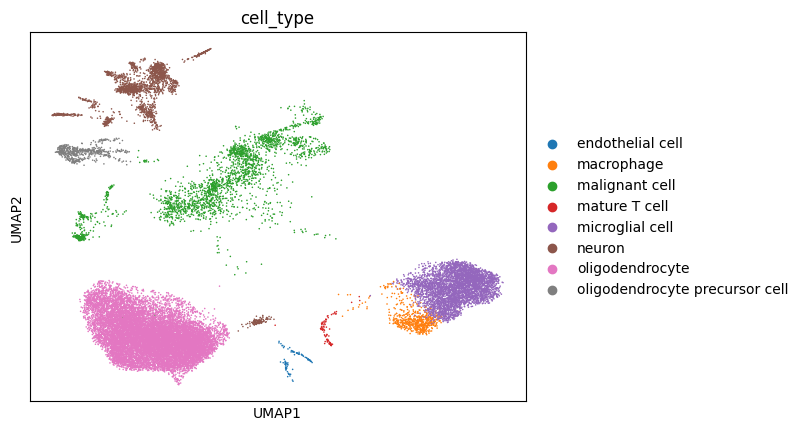

In [11]:
sc.pl.umap(bdata, color = 'cell_type')

In [19]:
cas_ontology_aware_response = cas.annotate_matrix_cell_type_ontology_aware_strategy(
    matrix=bdata,
    chunk_size=500,
    feature_ids_column_name='gene_id',
    feature_names_column_name='index',
    cas_model_name=None)

* [23:39:49.556] Cellarium CAS (Model ID: cellarium-pca-v1.1beta)
* [23:39:49.556] Total number of input cells: 23603
* [23:39:53.937] The input data matrix has 607 extra features compared to 'refdata-gex-GRCh38-2020-A' CAS schema (36601). Extra input features will be dropped.
* [23:39:53.937] The input data matrix has 13115 missing features compared to 'refdata-gex-GRCh38-2020-A' CAS schema (36601). Missing features will be imputed with zeros.
* [23:39:56.326] Submitting cell chunk # 1 (    0,   500) to CAS ...
* [23:39:56.667] Submitting cell chunk # 2 (  500,  1000) to CAS ...
* [23:39:56.933] Submitting cell chunk # 3 ( 1000,  1500) to CAS ...
* [23:39:57.160] Submitting cell chunk # 4 ( 1500,  2000) to CAS ...
* [23:39:57.367] Submitting cell chunk # 5 ( 2000,  2500) to CAS ...
* [23:39:57.535] Submitting cell chunk # 6 ( 2500,  3000) to CAS ...
* [23:39:57.695] Submitting cell chunk # 7 ( 3000,  3500) to CAS ...
* [23:39:57.854] Submitting cell chunk # 8 ( 3500,  4000) to CAS ...

In [27]:
insert_cas_ontology_aware_response_into_adata(cas_ontology_aware_response, bdata)

In [37]:
with suppress_stderr():
    cl = CellOntologyCache()

* [23:50:37.942] Loading cell ontology OWL from: https://github.com/obophenotype/cell-ontology/releases/download/v2024-01-04/cl.owl


In [38]:
pp.compute_most_granular_top_k_calls_single(
    adata=bdata,
    cl=cl,
    min_acceptable_score=0.2,  
    top_k=3,  
    obs_prefix="cas_cell_type" 
)

In [39]:
bdata.obs

,sample_id,tissue,patient_id,author,barcode,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,cell_type,cas_cell_type_score_1,cas_cell_type_name_1,cas_cell_type_label_1,cas_cell_type_score_2,cas_cell_type_name_2,cas_cell_type_label_2,cas_cell_type_score_3,cas_cell_type_name_3,cas_cell_type_label_3
S1V_ATCATTCCAAGCTGCC-1,S1V,SVZ,S1,tnl,ATCATTCCAAGCTGCC-1,6329,6329,8.753056,28048.0,10.241709,...,neuron,0.530751,CL_4023026,direct pathway medium spiny neuron,0.467617,CL_4023029,indirect pathway medium spiny neuron,0.998785,CL_1001474,medium spiny neuron
S1V_ACTTAGGGTACAGTAA-1,S1V,SVZ,S1,tnl,ACTTAGGGTACAGTAA-1,6943,6943,8.845633,27289.0,10.214275,...,neuron,0.452040,CL_4023026,direct pathway medium spiny neuron,0.511646,CL_4023029,indirect pathway medium spiny neuron,0.998803,CL_1001474,medium spiny neuron
S1V_TCCCACAAGCTGACTT-1,S1V,SVZ,S1,tnl,TCCCACAAGCTGACTT-1,6281,6281,8.745444,26132.0,10.170954,...,neuron,0.654972,CL_4023026,direct pathway medium spiny neuron,0.343442,CL_4023029,indirect pathway medium spiny neuron,0.998855,CL_1001474,medium spiny neuron
S1V_ATCACGACAACACACT-1,S1V,SVZ,S1,tnl,ATCACGACAACACACT-1,6389,6389,8.762490,25568.0,10.149136,...,neuron,0.447453,CL_4023026,direct pathway medium spiny neuron,0.543438,CL_4023029,indirect pathway medium spiny neuron,0.999304,CL_1001474,medium spiny neuron
S1V_ACCAAACAGCATGCGA-1,S1V,SVZ,S1,tnl,ACCAAACAGCATGCGA-1,6057,6057,8.709135,25111.0,10.131102,...,neuron,0.645312,CL_4023026,direct pathway medium spiny neuron,0.353034,CL_4023029,indirect pathway medium spiny neuron,0.998931,CL_1001474,medium spiny neuron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S6V_CGTGATATCGGAGCAA-1,S6V,SVZ,S6,tnl,CGTGATATCGGAGCAA-1,615,615,6.423247,798.0,6.683361,...,microglial cell,0.717160,CL_0000129,microglial cell,0.968985,CL_0000878,central nervous system macrophage,0.968985,CL_0000864,tissue-resident macrophage
S6V_CATGGATAGGATTTGA-1,S6V,SVZ,S6,tnl,CATGGATAGGATTTGA-1,592,592,6.385194,751.0,6.622736,...,microglial cell,0.815751,CL_0000129,microglial cell,0.976814,CL_0000878,central nervous system macrophage,0.976814,CL_0000864,tissue-resident macrophage
S6V_CCAAGCGTCGCTACAA-1,S6V,SVZ,S6,tnl,CCAAGCGTCGCTACAA-1,590,590,6.381816,779.0,6.659294,...,microglial cell,0.918984,CL_0000129,microglial cell,0.960889,CL_0000878,central nervous system macrophage,0.960889,CL_0000864,tissue-resident macrophage
S6V_AAGCATCGTGCCGTAC-1,S6V,SVZ,S6,tnl,AAGCATCGTGCCGTAC-1,551,551,6.313548,708.0,6.563856,...,microglial cell,0.902258,CL_0000129,microglial cell,0.970486,CL_0000878,central nervous system macrophage,0.970486,CL_0000864,tissue-resident macrophage


In [40]:
bdata.write('../../intermediate_output/4_cas_annotation_svz.h5ad')

In [41]:
cdata = adata[adata.obs.tissue == "Tumor"].copy()
cdata

AnnData object with n_obs × n_vars = 39046 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type'
    var: 'gene_id'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'ora_estimate', 'ora_pvals'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [44]:
cas_ontology_aware_response = cas.annotate_matrix_cell_type_ontology_aware_strategy(
    matrix=cdata,
    chunk_size=500,
    feature_ids_column_name='gene_id',
    feature_names_column_name='index',
    cas_model_name=None)

* [23:56:18.429] Cellarium CAS (Model ID: cellarium-pca-v1.1beta)
* [23:56:18.429] Total number of input cells: 39046
* [23:56:18.630] The input data matrix has 607 extra features compared to 'refdata-gex-GRCh38-2020-A' CAS schema (36601). Extra input features will be dropped.
* [23:56:18.630] The input data matrix has 13115 missing features compared to 'refdata-gex-GRCh38-2020-A' CAS schema (36601). Missing features will be imputed with zeros.
* [23:56:22.292] Submitting cell chunk # 1 (    0,   500) to CAS ...
* [23:56:22.765] Submitting cell chunk # 2 (  500,  1000) to CAS ...
* [23:56:22.914] Submitting cell chunk # 3 ( 1000,  1500) to CAS ...
* [23:56:23.076] Submitting cell chunk # 4 ( 1500,  2000) to CAS ...
* [23:56:23.217] Submitting cell chunk # 5 ( 2000,  2500) to CAS ...
* [23:56:23.360] Submitting cell chunk # 6 ( 2500,  3000) to CAS ...
* [23:56:23.489] Submitting cell chunk # 7 ( 3000,  3500) to CAS ...
* [23:56:23.623] Submitting cell chunk # 8 ( 3500,  4000) to CAS ...

In [45]:
insert_cas_ontology_aware_response_into_adata(cas_ontology_aware_response, cdata)

with suppress_stderr():
    cl = CellOntologyCache()

pp.compute_most_granular_top_k_calls_single(
    adata=cdata,
    cl=cl,
    min_acceptable_score=0.2,  
    top_k=3,  
    obs_prefix="cas_cell_type" 
)

* [00:01:10.371] Loading cell ontology OWL from: https://github.com/obophenotype/cell-ontology/releases/download/v2024-01-04/cl.owl


In [48]:
adata = sc.concat([bdata, cdata], join = 'outer')
adata

AnnData object with n_obs × n_vars = 62649 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3'
    obsm: 'X_scVI', 'X_umap', 'ora_estimate'

In [51]:
adata.write('../../intermediate_output/3_rough_annotation2.h5ad')